# Der mehrmensionale Kalman-Filter, Teil 1 Beispiele
25.7.2019, S. Mack

In [1]:
# display plots inside this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

## Was ist was beim mehrdimensionalen Kalman-Filter?

Nachfolgend sind nochmals alle Parameter und Startwerte eines mehrdimensionalen Kalman-Filters in einer Tabelle zusammengefasst. Alle diese Werte müssen für einen Kalmanfilter initialisiert werden. Wie man das genau macht, wurde im vorang gegangenen Jupyter-Notebook dargestellt.  



|Parameter bzw. Variable|Bedeutung|Typ|Bemerkung|
| :--------------------------- | :----------------------------------: | -------------------------------:|
| Prior, Vorhersagewert Zustandsvektor $\mathbf{\bar x}$ |Vorhersagewerte Zustandsgrößen|Vektor, 1D-Array|u.a. interner Rückgabewert ``predict()``, Eingangsgröße von ``update()``|
| Kovarianzmatrix Prior $\mathbf{\bar P}$ | Varianzen und Korrelationen | Matrix, 2D-Array| u.a. interner Rückgabewert ``predict()``, Eingangsgröße von ``update()``|
| Posterior, Korrekturwert Zustandsvektor $\mathbf{\hat x}$ |Erwartungswerte Zustandsgrößen, Filter Output|Vektor, 1D-Array|wird als Startwert $\mathbf{\hat x_0}$ vorgegeben, u.a. Rückgabewert ``update()``, Eingangsgröße von ``predict()``|
| Kovarianzmatrix Posterior $\mathbf{\hat P}$ | Varianzen und Korrelationen, Filter Output | Matrix, 2D-Array| wird als Startwert $\mathbf{\hat P_0}$ vorgegeben mit Kovarianzen = 0, u.a. Rückgabewert ``update()``, Eingangsgröße von ``predict()``|
| Übergangsmatrix $\mathbf F$ | beinhaltet physikalisches Modell | Matrix, 2D-Array| Funktion für Vorhersage, kommt aus Differentialgleichung des Prozesses, Parameter von ``predict()``|
| Kovarianzmatrix Prozessrauschen $\mathbf Q$ | Unsicherheiten des Modells | Matrix, 2D-Array| Näherungsweise berechnet über reale Schwankungen des Prozesses, Parameter von ``predict()``|
| Steuer-/Störgröße $\mathbf u$ | externe Steuer-/Störgröße auf Prozess | Vektor, 1D-Array| Parameter von ``predict()``, wird hier nicht verwendet|
| Steuer-/Störmatrix $\mathbf B$ | Wirkung externer Steuer-/Störgrößen auf Prozess | Matrix, 2D-Array| Parameter von ``predict()``, wird hier nicht verwendet|
| Beobachtungsmatrix $\mathbf H$ | Transformiert Zustandsgröße in Messgröße | Matrix, 2D-Array| Parameter von ``update()``, wird hier = 1 angenommen, da Größe Zustand und Messung identisch|
| Messwertvektor $\mathbf z$ |Enthält verrauschte Messwerte|Vektor|Eingangsgröße von ``update()``|
| Kovarianzmatrix Messwerte $\mathbf R$ | Messunsicherheiten in Form von Varianzen (und Korrelationen)  | Matrix, 2D-Array| Parameter von ``update()`` für Gegenüberstellung Relevanz Messwert-Vorhersagewert|
| Residuum $\mathbf y$ | Differenz Vorhersage- und Messwert|Vektor|wird in Einheiten des Messwertes berechnet|
| Kalman Gain $\mathbf K$ | Berechnung Verhältnis Relevanz Mess- und Vorhersagewert | Matrix, 2D-Array| Berechnung über Varianzen und damit Verortung des Korrekturwertes|

Und hier sind nochmals die grundlegenden Kalman-Gleichungen dargestellt. Dazu wird die selbe Notation verwendet wie in den voran gegangenen Jupyter-Notebooks:  

<u>Vorhersage</u>

$\begin{array}{|l|l|l|}
\hline
\text{Notation} &  \text{Notation}& \text{Notation}\\
\text{eindim. Statistik} & \text{eindim. Kalman} & \text{mehrdim. Kalman}\\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = \hat x + dx & \bar{\mathbf x} = \mathbf{F \hat x} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

<u>Korrektur</u>

$\begin{array}{|l|l|l|}
\hline
\text{Notation} &  \text{Notation}& \text{Notation}\\
\text{eindim. Statistik} & \text{eindim. Kalman} & \text{mehrdim. Kalman}\\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & \hat x = \bar x + Ky & \mathbf{\hat x} = \mathbf {\bar x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

## Implementierung des Vorhersage- und Korrektur-Algorithmus
Der Vorhersage-Algorithmus wurde schon im voran gegangenen Jupyter-Notebook in Python implementiert. Er wird hier nochmals unverändert dargestellt:

In [2]:
def predict(x, P, F, Q, B, u):
    '''Kalman Filter predict step'''
    x_prior = np.dot(F, x)+ np.dot(B, u)
    P_prior = np.dot(F, P).dot(F.T) + Q # A.dot(B) is the same as np.dot(A,B)
    return x_prior,P_prior 

Somit bleibt noch die Implementierung des Korrektur-Algorythmus übrig. Dafür wird die Mathematik aus der unteren Tabelle oben in Python-Code wie folgt implementiert:

In [3]:
from scipy.linalg import inv

def update(x, P, H, R, z):
    '''Kalman Filter update step'''
    S = np.dot(H, P).dot(H.T) + R
    K = np.dot(P, H.T).dot(inv(S))
    y = z - np.dot(H, x)
    x_post = x + np.dot(K, y)
    P_post = P - np.dot(K, H).dot(P)  
    return x_post, P_post

## Vorbereitung für die Simulation und das anschließende zweidimesionale Kalman-Tracking eines Roboterfahrzeugs

<img src="RoboFahrzeug15Grad.png" width="400">
Wie im schon bekannten Bild oben dargestellt, fährt das Roboterfahrzeug geradlinig schräg zu einer Wand. Gemessen wird der Abstand zur Wand. Die Bewegung dieses Fahrzeugs wird simuliert, um anschließend anhand der erzeugten Sensordaten die Wirkung des mehrdimensionalen Kalman-Filters zu untersuchen.  

Um den neuen zweidimensionalen Kalman-Filter zu testen, wird nachfolgend der Code für die Simulation des Roboterfahrzeugs wiederholt:

### Simulation des Roboterfahrzeugs

Der Konstruktor ``RoboSim(x0,velocity,process_var,measurement_var)`` erhält folgende Variablen übergeben: 
* ``x0``: Startposition des Roboters. 
* ``velocity``: Die (mittlere) Positionsänderung pro Iteration, also der Erwartungswert der Geschwindigkeit.
* ``process_var``: Die Varianz des gaussförmigen Porzessrauschens, hier im mehrdimensionalen Kalmanfilter nicht ``velocity`` sondern die Position beaufschlagt wird. Der Roboter bewegt sich realitätsnah *nicht* auf einer absolut geraden Linie.
* ``measurement_var``: Die Varianz der Messunsicherheit des Positionssensors, also des Messrauschens.  
  
Die Methode `sense_position()` schlägt auf den schon durch das Prozessrauschen leicht verrauschten wahren Positionswert zusätzlich ein signifikantes Messrauschen auf.  

In [4]:
import copy # needed for deepcopy() ín move_and_sense()
from collections import namedtuple
gaussian = namedtuple('Gaussverteilung', ['mean', 'var'])

class RoboSim(object):
    def __init__(self, x0=0, velocity=1, process_var=0.0, measurement_var=0.0):
        '''currently no control input u is implemented: u = 0 for all time steps.
        x0: initial position. process_var: position variance in process (m)^2. 
        measurement_var: variance in position measurement m^2. dt: time step size'''
        self.x = x0
        self.velocity = velocity
        self.measurement_noise = np.sqrt(measurement_var)
        self.process_noise = np.sqrt(process_var)

    def move(self, dt):
        '''compute new position of the robot assuming `dt` seconds have passed 
        since last update with process_noise added to position (not velocity)'''
        velocity = self.velocity
        self.x += velocity * dt + np.random.randn() * self.process_noise

    def sense_position(self):
        '''simulates measuring the position with measurement noise'''
        return self.x + np.random.randn() * self.measurement_noise

    def move_and_sense(self, dt):
        '''true noisy position, measured position of robot, control value u=0'''
        self.move(dt)
        x = copy.deepcopy(self.x)
        return x, self.sense_position(), 0 

    def run_simulation(self, count=1, dt=1):
        '''simulates the robot moving over a period of time and returns data: 
        (3,count) size array, column 0: true robot position, column 1: measurement
        robot position, column 2: control value (currently allways zero)'''
        return np.array([self.move_and_sense(dt) for i in range(count)])

### Hilfsfunktionen
#### Anwendung des Kalmanfilters und Erzeugung von Daten für die grafische Darstellung
Die Funktion ``kal_filt_2dim_for_plot()`` führt auf den vorher simulierten Daten ``sim_data`` einen zweidimensionalen Kalmanfilter aus mit den Größen "Abstand" und "Abstandsänderung" des Roboterfahrzeugs als Zustandsgrößen. Die Zustandsgröße "Abstandsänderung" ist eine verborgene Zustandsgröße.  
Die Rückgabewerte dieser Funktion sind für jeden Iterationsschritt des Kalman-Filters jeweils der Zustandsvektor des Priors (Vorhersage) inkl. Kovarianzmatrix sowie der Zustandsvektor des Posteriors (Korrekturwert bzw. Schätzwert) inkl Kovarianzmatrix.

In [5]:
def kal_filt_2dim_for_plot(sim_data, x_start, P_start, F, Q, H, R):
    '''Performs 2-dim Kalman filtering for subsequent plotting on data set
    sim_data with sim_data[1]: Measurements. sim_data[2]: control values u.
    Returns priors, posteriors of state vectors with standard deviations 
    '''    
    prior=[] # needed for subsequent plotting
    prior_std=[]
    posterior=[]
    posterior_std=[]
    print('d wahr \t d vorh +/-Std     d mess +/-Std     d korr +/-Std     v korr +/-Std')
    # perform Kalman filter on simulated measurement data simdata[1,:]
    x = x_start
    P = P_start
    for val in sim_data:    
        x_prior,P_prior = predict(x, P, F, Q, B, val[2])
        x_post,P_post = update(x_prior, P_prior, H, R, val[1])
        print('{:6.3f}\t{:6.3f} +/-{:6.3f}  {:6.3f} +/-{:6.3f}  {:6.3f} +/-{:6.3f}  {:6.3f} +/-{:6.3f}'.format
              (val[0],x_prior[0,0],np.sqrt(P_prior[0,0]),val[1],np.sqrt(sensor_var),
               x_post[0,0],np.sqrt(P_post[0,0]),x_post[1,0],np.sqrt(P_post[1,0])))
        prior.append(x_prior[0])
        prior_std.append(np.sqrt(P_prior[0,0]))
        posterior.append(x_post)
        posterior_std.append(np.sqrt(P_post[0,0]))
        x = x_post
        P = P_post
    return prior, prior_std, posterior,posterior_std 

#### Grafische Darstellung der Simulationsdaten inkl. der Kalman-Filterschätzwerte
Die Funktion ``plot_kal_filt_2dim()`` erstellt aus Daten der Simulation sowie aus dem Output des darauf angewendeten zweidimensionalen Kalman-Filters eine grafische Darstellung. 

In [6]:
def plot_kal_filt_2dim(val_true,val_meas, est_x0, est_x1, dt):
    '''Plots the results of a twodimensional Kalman fiter with hidden second
    state variable x1. Needs as input: true value of x0, measured value of x0, 
    estimate of x0 and estimate of x1, time step size dt'''
    fig, ax1 = plt.subplots(figsize=(10,4))
    time = np.linspace(dt,n*dt, n)
    ax1.plot(time,val_true,color='k',mfc='None',marker = 'None',linestyle=':',linewidth = 0.5,label='wahrer Wert')
    ax1.plot(time,val_meas,color='C2',mfc='None',marker = 'o',linestyle='None',label='Messwert')
    ax1.plot(time,est_x0,color='C1',mfc='None',marker = '+',linestyle='-.',linewidth = 1,label='Schätzwert $d$')
    ax1.set_xlabel('Zeit (s)')
    ax1.tick_params('y', colors='C1')
    ax1.set_ylabel('Abstand $d$ (m)', color='C1')
    ax2 = ax1.twinx() # second y-axis
    ax2.plot(time, est_x1,color='C0',mfc='None',marker = '+',linestyle='--',linewidth = 1,label='Schätzwert $\dot d$')
    ax2.tick_params('y',colors='C0')
    ax2.set_ylabel('Abstandsänderung $\dot d$ (m/s)',color='C0')
    ax2.set_ylim(0,0.1)
    fig.legend(loc='upper left',bbox_to_anchor=(0,1),bbox_transform=ax1.transAxes) # places common legend for both axes

#### Berechnung der Kovarianzmatrix des Prozessrauschens über die erwartete (tatsächliche) Abweichung der Fahrspur von einer geraden Linie
Wie im vorhergehenden Jupyter-Notebook dargestellt, kann die Kovarianzmatrix $\mathbf Q$ für das hier betrachtete Roboterfahrzeug mit der Funktion ``Q_zero_mean()`` berechnet werden:

In [7]:
def Q_zero_mean(dim, dt=1., var=1):
    '''generates start value state covarince matrix based on given estimated
    for variance of position (element zero of state value vector)'''
    if not (dim == 2 or dim == 3 or dim == 4):
        raise ValueError("dim must be between 2 and 4")
    if dim == 2:
        Q = np.array([[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]])
    elif dim == 3:
        Q = np.array([[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]])
    else:
        Q = np.array([[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]])
    return Q*var


## Untersuchung des zweidimensionalen Kalman-Filters anhand von Simulationen eines Roboterfahrzeugs
Eine Simulation besteht immer aus drei Schritten:
1. Den Kalman-Filter und dessen Parameter initialisieren.
2. Für eine vorgegebene Geschwindigkeit des Roboterfahrzeugs die wahren (auch leicht verrauschten) Positionsdaten und die entsprechenden (stärker verrauschen) Sensormessdaten dazu erzeugen.
3. Die Kalman-Filterung durchführen
4. Den Verlauf der Schätzwerte für Abstand und Abstandsänderung, der wahren und gemessenen Abstände grafisch darstellen.

In den folgenden Abschnitten werden mit verschiedenen Parametern und Randbedingungen Simulationen der Fahrzeugbewegung und eine anschließende Kalman-Filterung durchgeführt.

### Erste Simulation mit realitätsnahen Annahmen für Roboterfahrzeug aus Sensorsysteme-Projekt
#### Schritt 1: Initialisierungswerte und Parameter für den zweidimensionalen Kalman-Filter zum Tracken des simulierten Roboterfahrzeugs
Im vorherigen Jupyter-Notebook wurden folgende Initialisierungswerte und Parameter hergeleitet, berechnet und implementiert. Nachfolgend werden jeweils solche Werte verwendet, die in etwa den realen Werten für das Roboterfahrzeug im Sensorsystemeprojekt entsprechen.

In [8]:
# initializing the Kalman Filter, parameter setting
dt=1
x_start = np.array([[0.25],[0.01]])
P_start = np.diag([0.25, 0.0009])
F = np.array([[1, dt],[0, 1]])
Q = Q_zero_mean(dim=2, dt=dt, var=0.000025) # var=0.000025
B = 0
sigma_z = 0.07
R = np.array([[sigma_z**2]])
H = np.array([[1., 0.]])

#### Schritt 2: Durchführung der Simulation der Bewegung des Roboterfahrzeugs
Für die Simulation der Bewegung des Roboterfahrzeugs müssen noch die Varianz der Abstandsmessung sowie die Varianz des Prozesses (also wie weit die tatsächliche Fahrspur des Fahrzeugs von einer geraden Linie abweicht) festgelegt werden. Es wird dafür jeweils das Element (0,0) aus dem Matrizen $\mathbf Q$ und $\mathbf R$ verwendet. Damit ist sicher gestellt, dass die Annahmen im Kalman-Filter über das Prozess- und Messwertrauschen immer denen der simulierten Bewegung entsprechen.   
Weiter müssenen noch die Anzahl der Schritte, die Abtastzeit ``dt`` sowie der Startabstand und die Abstandsänderung als Eingangsdaten für diese Simulation spezifiziert werden. 

In [9]:
# set parameters for robot car movement simulation
process_var = Q[0,0] # variance of robot distance, same as later in Kalman filter
sensor_var = R[0,0] # variance distance sensor, same as later in Kalman filter
n = 20 # number of data sets to be simulated
start_pos_sim = 0 # start position
vel_sim = 0.05 # constant velocity value

robot = RoboSim(x0=start_pos_sim,velocity=vel_sim,measurement_var=sensor_var,process_var=process_var)
# create list of measurements spaced by dt
np.random.seed(13) # to make the simulation reproducible
sim_data = robot.run_simulation(count=n,dt=dt)

#### Schritt 3: Kalman-Filterung

In [10]:
# perform twodimensional Kalman filtering
priors,priors_std,posts,posts_std = kal_filt_2dim_for_plot(sim_data, x_start, P_start, F, Q, H, R)

d wahr 	 d vorh +/-Std     d mess +/-Std     d korr +/-Std     v korr +/-Std
 0.048	 0.260 +/- 0.501   0.101 +/- 0.070   0.104 +/- 0.069   0.009 +/- 0.004
 0.098	 0.113 +/- 0.076   0.130 +/- 0.070   0.122 +/- 0.051   0.011 +/- 0.021
 0.151	 0.133 +/- 0.066   0.189 +/- 0.070   0.159 +/- 0.048   0.019 +/- 0.026
 0.205	 0.178 +/- 0.066   0.265 +/- 0.070   0.219 +/- 0.048   0.032 +/- 0.027
 0.259	 0.251 +/- 0.066   0.185 +/- 0.070   0.220 +/- 0.048   0.023 +/- 0.026
 0.307	 0.243 +/- 0.063   0.218 +/- 0.070   0.232 +/- 0.047   0.020 +/- 0.024
 0.358	 0.252 +/- 0.060   0.341 +/- 0.070   0.290 +/- 0.046   0.029 +/- 0.022
 0.410	 0.319 +/- 0.057   0.432 +/- 0.070   0.364 +/- 0.044   0.039 +/- 0.021
 0.461	 0.403 +/- 0.055   0.611 +/- 0.070   0.482 +/- 0.043   0.055 +/- 0.019
 0.512	 0.537 +/- 0.053   0.510 +/- 0.070   0.527 +/- 0.042   0.053 +/- 0.019
 0.560	 0.580 +/- 0.051   0.643 +/- 0.070   0.602 +/- 0.041   0.057 +/- 0.018
 0.612	 0.659 +/- 0.050   0.536 +/- 0.070   0.618 +/- 0.041   0.0

#### Schritt 4: Grafische Darstellung der Ergebnisse

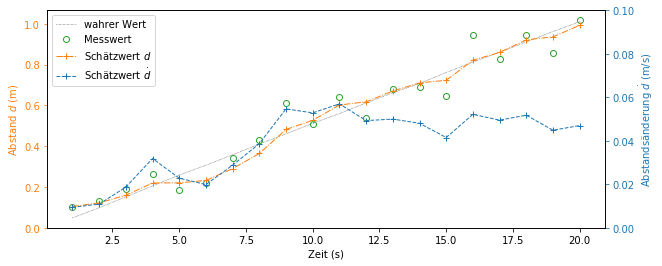

In [11]:
# plot kalman filter output togehter with simulated data
plot_kal_filt_2dim([val[0] for val in sim_data],[val[1] for val in sim_data],
                   [val[0,0] for val in posts],[val[1,0] for val in posts],dt)

Die oben dargestellte Simulation basiert auf recht realistischen Annahmen für das im Sensorsystemeprojekt verwendete Roboterfahrzeug. Es ist schön zu sehen, wie die zweite (verdeckte) Zustandsgröße "Abstandsänderung" recht schnell vom Filter bestimmt wird, obwohl im Startwert des Filters eine doppelt so große Änderung angenommen wurde.

### Simulation mit sehr schlechten Startwerten für Abstand und Abstandsänderung und normalem Rauschen
Der eindimensionale Kalman-Filter war nicht robust gegenüber einer falsch angenommenen Abstandsänderung im physikalischen Modell. Hier im zweidimensionalen Fall kann problemlos ein Startwert dafür angenommen werden, der erheblich von der wahren Abstandsänderung abweicht.  
Ein schlechter Startwert für die Anfangsposition konnte schon der eindimensionale Kalman-Filter kompensieren. Hier im zweidimensionalen Fall konvergiert der Filter jedoch wesentlich schneller. 

d wahr 	 d vorh +/-Std     d mess +/-Std     d korr +/-Std     v korr +/-Std
 0.048	 1.200 +/- 0.501   0.101 +/- 0.070   0.122 +/- 0.069   0.396 +/- 0.004
 0.098	 0.518 +/- 0.076   0.130 +/- 0.070   0.308 +/- 0.051   0.361 +/- 0.021
 0.151	 0.670 +/- 0.066   0.189 +/- 0.070   0.442 +/- 0.048   0.294 +/- 0.026
 0.205	 0.736 +/- 0.066   0.265 +/- 0.070   0.513 +/- 0.048   0.222 +/- 0.027
 0.259	 0.735 +/- 0.066   0.185 +/- 0.070   0.478 +/- 0.048   0.147 +/- 0.026
 0.307	 0.625 +/- 0.063   0.218 +/- 0.070   0.442 +/- 0.047   0.099 +/- 0.024
 0.358	 0.541 +/- 0.060   0.341 +/- 0.070   0.456 +/- 0.046   0.079 +/- 0.022
 0.410	 0.535 +/- 0.057   0.432 +/- 0.070   0.494 +/- 0.044   0.070 +/- 0.021
 0.461	 0.564 +/- 0.055   0.611 +/- 0.070   0.582 +/- 0.043   0.074 +/- 0.019
 0.512	 0.655 +/- 0.053   0.510 +/- 0.070   0.603 +/- 0.042   0.064 +/- 0.019
 0.560	 0.667 +/- 0.051   0.643 +/- 0.070   0.658 +/- 0.041   0.062 +/- 0.018
 0.612	 0.720 +/- 0.050   0.536 +/- 0.070   0.659 +/- 0.041   0.0

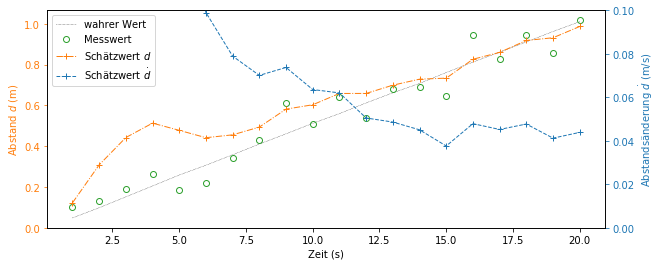

In [12]:
x_start = np.array([[0.8],[0.4]])
P_start = np.diag([0.25, 0.0009])

priors,priors_std,posts,posts_std = kal_filt_2dim_for_plot(sim_data, x_start, P_start, F, Q, H, R)
plot_kal_filt_2dim([val[0] for val in sim_data],[val[1] for val in sim_data],
                   [val[0,0] for val in posts],[val[1,0] for val in posts],dt)

### Simulation mit sehr hohem Messwertrauschen und guten Startwerten
Die eigentliche Filterwirkung auf den Zustandswert "Abstand" steht hier im Fokus: Selbst bei stark verrauschten Messwerten liefert der mehrdimensionale Kalman-Filter einen recht glatten Schätzwertverlauf, der nahe bei den wahren Abstandswerten liegt.

d wahr 	 d vorh +/-Std     d mess +/-Std     d korr +/-Std     v korr +/-Std
 0.048	 0.260 +/- 0.501   0.124 +/- 0.100   0.129 +/- 0.098   0.010 +/- 0.006
 0.098	 0.138 +/- 0.103   0.143 +/- 0.100   0.141 +/- 0.072   0.010 +/- 0.022
 0.151	 0.151 +/- 0.084   0.205 +/- 0.100   0.173 +/- 0.064   0.014 +/- 0.029
 0.205	 0.187 +/- 0.081   0.291 +/- 0.100   0.228 +/- 0.063   0.024 +/- 0.031
 0.259	 0.253 +/- 0.081   0.154 +/- 0.100   0.213 +/- 0.063   0.014 +/- 0.032
 0.307	 0.228 +/- 0.081   0.180 +/- 0.100   0.209 +/- 0.063   0.010 +/- 0.031
 0.358	 0.219 +/- 0.079   0.334 +/- 0.100   0.263 +/- 0.062   0.020 +/- 0.029
 0.410	 0.283 +/- 0.076   0.442 +/- 0.100   0.342 +/- 0.061   0.031 +/- 0.027
 0.461	 0.373 +/- 0.074   0.676 +/- 0.100   0.480 +/- 0.059   0.051 +/- 0.026
 0.512	 0.531 +/- 0.071   0.509 +/- 0.100   0.524 +/- 0.058   0.050 +/- 0.024
 0.560	 0.574 +/- 0.069   0.679 +/- 0.100   0.607 +/- 0.057   0.056 +/- 0.023
 0.612	 0.663 +/- 0.067   0.503 +/- 0.100   0.614 +/- 0.056   0.0

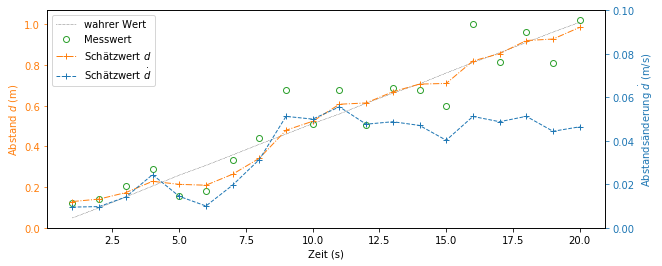

In [13]:
x_start = np.array([[0.25],[0.01]])
P_start = np.diag([0.25, 0.0009])
sigma_z = 0.1
R = np.array([[sigma_z**2]])
sensor_var = R[0,0] # variance distance sensor, same as later in Kalman filter
robot = RoboSim(x0=start_pos_sim,velocity=vel_sim,measurement_var=sensor_var,process_var=process_var)
np.random.seed(13) # to make the simulation reproducible
sim_data = robot.run_simulation(count=n,dt=dt)
priors,priors_std,posts,posts_std = kal_filt_2dim_for_plot(sim_data, x_start, P_start, F, Q, H, R)
plot_kal_filt_2dim([val[0] for val in sim_data],[val[1] for val in sim_data],
                   [val[0,0] for val in posts],[val[1,0] for val in posts],dt)

## Korrespondenz der Bezeichnungen zum Buch "Kalman-Filter" von R. Marchthaler  und S. Dingler
Dieses aktuelle Buch bietet die Möglichkeit, sich tiefer in den Thematik des Kalman-Filters einzuarbeiten. Hier sind auch die nötigen theoretischen Grundlagen erklärt.  
Damit der Umstieg von diesem Jupyter-Notebook auf das Fachbuch gelingt, sind in der Tabelle die Begrifflichkeiten verglichen.

|Parameter/Variable in diesem Notebook|entsprechender Parameter/Variable Marchthaler|Bemerkung|
| :--------------------------- | :----------------------------------: | -------------------------------:|
| Prior, Vorhersagewert Zustandsvektor $\mathbf{\bar x}$ |prädizierter Zustandsvektor $\hat {\underline x}(k)$|-|
| Kovarianzmatrix Prior $\mathbf{\bar P}$ | prädizierte Kovarianz des Schätzfehlers $\hat{\underline P}(k)$ |-|
| Posterior, Korrekturwert Zustandsvektor $\mathbf{\hat x}$ | Korrigierter Zustandsvektor $\tilde {\underline x}(k)$ |-|
| Kovarianzmatrix Posterior $\mathbf{\hat P}$ | korrigierte Kovarianz des Schätzfehlers $\tilde{\underline P}(k)$ |-|
| Übergangsmatrix $\mathbf F$ | Systemmatrix ${\underline A}_d$|-|
| Kovarianzmatrix Prozessrauschen $\mathbf Q$ | Systemrauschen ${\underline Q}(k)$ |wird vor Addition zu $\hat{\underline P}(k)$ mit zusätzlicher Matrix ${\underline G}_d$ transformiert|
| Steuer-/Störgröße $\mathbf u$ | $\underline u(k)$ |-|
| Steuer-/Störmatrix $\mathbf B$ | ${\underline B}_d$ |zusätzliche Durchgangsmatrix ${\underline D}$ bei Korrekturschritt, |
| Beobachtungsmatrix $\mathbf H$ | $\underline C$ |-|
| Messwertvektor $\mathbf z$ | Ausgangsvektor ${\underline y}(k)$ |-|
| Kovarianzmatrix Messwerte $\mathbf R$ | Varianz Messrauschen ${\underline R}(k)$ |${\underline R}(k) = Var(\underline v(k))$ mit Messrauschen $\underline v(k)$|
| Residuum $\mathbf y$ | $\Delta \underline y(k)$|-|
| Kalman Gain $\mathbf K$ | Kalmanverstärkung $\underline K$ |-|


In der Einleitung dieses Buchs ist am Beispiel der Mondlandefähre der Kalman-Filter erklärt. Hier handelt es sich um einen dreidimensionalen Kalman-Filter, bei dem der Zustandsvektor aus der Ortskoordinate h, der Geschwindigkeit v und der Beschleunigung a besteht. Messwerte existieren nur für h und a. v ist also ein verdeckter Zustand.  

Leider ist diese Lehrbuch recht ungeeignet für eine intuitive Einführung in die Thematik. Die vorliegende Reihe von Jupyter-Notebooks ist letztendlich ein Ergebnis der erfolglosen Auseinandersetzung des Autors mit dem Lehrbuch von Marchthaler/Dingler.  

Mit Filteralgorithmen muss man spielen, um sie zuerst intuitiv zu verstehen. Danach ist es erst möglich, die zugrunde liegende Theorie zu verstehen.

## Schlussbemerkung

**Das Ziel dieser Reihe von Jupyter-Notbooks war eine leicht verständliche Einführung in den Kalman-Filter ohne allzu viel Theorie in Form von Wahrscheinlichkeitsrechnung.**  
Der Kalman-Filter gehört zu den Bayes-Filtern, die Bayes-Filter verwenden den Vorhersage-/Korrektur-Algorithmus des g-h-Filters. Aus diesem Grund wurde nicht der direkte Weg zum Kalmanfilter sondern der Umweg zuerst über den g-h-Filter und anschließend über den Bayes-Filter eingeschlagen.    
Der Kalman-Filter basiert auf der Gaußschen Wahrscheinlichkeitsrechnung, weshalb hierzu sowohl für den eindimensionalen als auch für den mehrdimensionalen Fall die Grundlagen behandelt wurden.  

Das erste Etappenziel war der eindimensionale Kalmanfilter. Jedoch ist dessen Nützlichkeit recht beschränkt: Er wirkt nicht wesentlich besser als ein Mittelwert- oder Medianfilter. Die Vorteile des Kalman-Filters treten erst im mehrdimensionalen Fall zutage, wenn mehrere Zustandsgrößen getrackt werden. Sind diese miteinander korreliert, dann ist es sogar möglich Werte für Zustandsgrößen aus einem Kalman-Filter zu beziehen, für die es keine Sensoren gibt. Auch die eigentliche Filterwirkung auf eine gemessene Zustandsgröße ist dann erheblich besser.

>**Am Ende dieser Jupyter-Notebook-Reihe ist es wichtig zu erkennen, dass der hier am Beispiel eines Roboterfahrzeugs entwickelte Kalman-Filter *generisch* ist.** D.h. die hier entwickelten Algorithmen und Codebeispiele können 1:1 auf ganz andere "Prozesse" sprich Anwendungen übertragen werden. Selbst in der Finanzindustrie verwendet man Kalman-Filter. Dort sind beispielsweise die beiden Zustandsgrößen der Börsenwert und der Minutenumsatz einer Aktie. 

Die Begrifflichkeiten in fast allen Lehrbüchern zum Kalman-Filter sind zwar mathematisch korrekt und in sich konsistent, jedoch nicht immer hilfreich für das Verstehen. Matrizenrechnung ist nicht jedermanns Steckenpferd! Und einige Lehrbücher enthalten viele Notationsfehler.   
Daher wurde hier der Kalman-Filter mit ganz einfacher Mathematik entwickelt. Erst spät wurde dann die Brücke zur üblichen Notation in den Lehrbüchern geschlagen.  

Python wie auch MATLAB eignen sich ideal, sich dem Thema Kalman-Filter experimentell quasi spielerisch zu näheren. Dies in Kombination mit einem guten weiterführenden Lehrbuch ist vermutlich das Erfolgsrezept, um später einmal einen Kalman-Filter in einem autnom fahrenenden Auto oder in einem Batteriemanagementsystem erfolgreich einzusetzen.